# Addictive Model

## Libraries

In [12]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus

## Import Dataset

In [13]:
file_path = '../data/food_data_cleaned1.xlsx'
food_data = pd.ExcelFile(file_path)

In [14]:
data = food_data.parse('Sheet1')
data.head()

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Categories,Countries,Barcode,Nutri-Score,Ecoscore
0,Sésame,1961.0,17.0,2.0,0.38,10.0,4.6,0,"Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",en:france,3175680011480,b,57
1,Lindt Excellence 90% 100g,2590.0,7.0,30.0,0.03,10.0,14.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:algeria, en:belgium, en:czech-republic, en:...",3046920029759,d,29
2,Excellence 85% Cacao Chocolat Noir Puissant,2418.0,15.0,27.0,0.02,12.5,0.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:austria, en:belgium, en:france, en:germany,...",3046920022606,e,29
3,Cashews,2510.0,6.5,9.0,0.02,20.5,5.2,100,"Plant-based foods and beverages,Plant-based fo...","en:austria, en:belgium, en:croatia, en:france,...",20267605,b,30
4,Tuc Original,2021.0,7.1,9.0,1.70,8.3,2.4,0,"Imbiss,Salzige Snacks,Vorspeisen,en:Biscuits a...","en:austria, en:belgium, en:denmark, en:estonia...",5410041001204,e,62


Preprocessing

In [15]:
nutri_score_mapping = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}
data['Nutri-Score'] = data['Nutri-Score'].map(nutri_score_mapping)

In [16]:
data

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Categories,Countries,Barcode,Nutri-Score,Ecoscore
0,Sésame,1961.0,17.0,2.0,0.38,10.0,4.6,0,"Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",en:france,3175680011480,4,57
1,Lindt Excellence 90% 100g,2590.0,7.0,30.0,0.03,10.0,14.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:algeria, en:belgium, en:czech-republic, en:...",3046920029759,2,29
2,Excellence 85% Cacao Chocolat Noir Puissant,2418.0,15.0,27.0,0.02,12.5,0.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:austria, en:belgium, en:france, en:germany,...",3046920022606,1,29
3,Cashews,2510.0,6.5,9.0,0.02,20.5,5.2,100,"Plant-based foods and beverages,Plant-based fo...","en:austria, en:belgium, en:croatia, en:france,...",20267605,4,30
4,Tuc Original,2021.0,7.1,9.0,1.70,8.3,2.4,0,"Imbiss,Salzige Snacks,Vorspeisen,en:Biscuits a...","en:austria, en:belgium, en:denmark, en:estonia...",5410041001204,1,62
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,"Alpro Sojadrink, Ungesüßt 1L",138.0,0.0,0.3,0.09,3.3,0.6,0,"Plant-based foods and beverages, Beverages, Pl...","en:belgium, en:france, en:germany, en:italy, e...",5411188115496,5,88
298,Cola Cao El Original,288.0,9.1,1.1,0.12,3.4,0.5,0,"Beverages,Breakfasts,Cocoa and its products,Co...","en:france, en:spain",8410014478733,4,0
299,Gnocchi à poêler,801.0,1.5,0.3,1.10,5.0,2.6,0,"Plant-based foods and beverages,Plant-based fo...",en:france,3240931548111,4,82
300,Tartines craquantes à la châtaigne,1616.0,6.5,0.5,0.30,6.7,4.3,0,"Plant-based foods and beverages, Plant-based f...",en:france,6175634,5,75


## Weighted Model

The weighted sum model combines multiple criteria into a single score. Here, we combine **Nutri-Score** (nutritional value) and **Eco-Score** (environmental impact).

Formula:
\[ F(x) = w_1 \times \text{Nutri-Score} + w_2 \times \text{Eco-Score} \]

Where:
- \( F(x) \): Comprehensive score.
- \( w_1, w_2 \): Weights for Nutri-Score and Eco-Score.
- Nutri-Score: Nutritional value.
- Eco-Score: Environmental impact.

Weight Selection:
- \( w_1 > w_2 \) if health is prioritized.
- \( w_1 = w_2 \) for equal importance.

Advantages:
- **Simple**: Easy to compute.
- **Flexible**: Adjust weights for priorities.
- **Transparent**: Clear score combination.

Limitations:
- **Linearity**: Cannot capture complex interactions.
- **Weight Sensitivity**: Scores depend on weights.

In [ ]:
w1, w2 = 0.6, 0.4

# Calculate weighted sum score
data['Comprehensive Score'] = w1 * data['Nutri-Score'] + w2 * data['Ecoscore']

min_score = data['Comprehensive Score'].min()
max_score = data['Comprehensive Score'].max()
data['Scaled Score'] = 1 + 4 * (data['Comprehensive Score'] - min_score) / (max_score - min_score)

data['Scaled Score'] = (data['Scaled Score'] * 2).round() / 2

data_sorted = data.sort_values(by='Scaled Score', ascending=False)

print(data_sorted[['Food Name', 'Nutri-Score', 'Ecoscore', 'Scaled Score']])
data_sorted.to_csv('weighted_sum_scaled_results.csv', index=False)

                                             Food Name  Nutri-Score  Ecoscore  \
5                                        Pulco Zitrone            3       112   
257                            BISCOTTES COMPLETES BIO            5       110   
151  Houmous extra - Pois chiches français & graine...            5        86   
154                                       Lait de coco            3        92   
215                      Tartined Craquantes Châtaigne            4        95   
..                                                 ...          ...       ...   
201                                Chavroux Pur Chèvre            3        10   
239  Banania Original - Cacao Céréales Touche De Ba...            4        -7   
298                               Cola Cao El Original            4         0   
109                                           Original            4       -17   
91                                            Le Choco            4       -20   

     Scaled Score  
5      

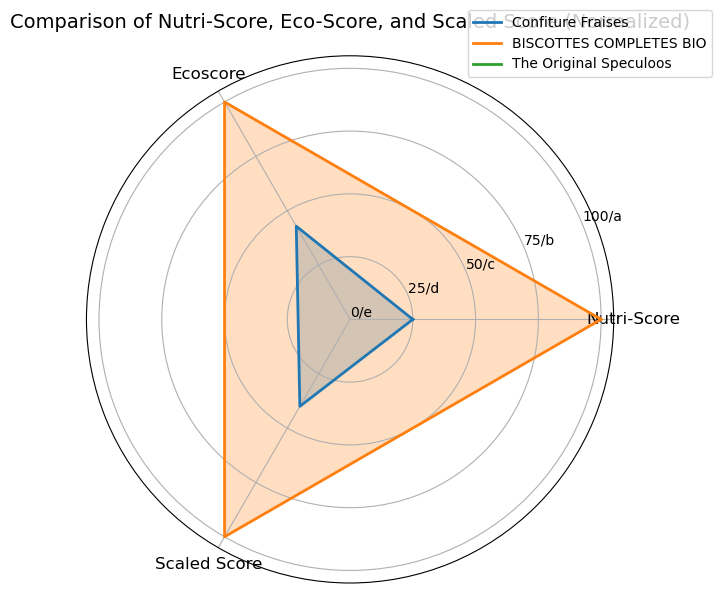

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)
random_3 = data.sample(3).reset_index()

categories = ['Nutri-Score', 'Ecoscore', 'Scaled Score']

for col in categories:
    random_3[col] = 100 * (random_3[col] - random_3[col].min()) / (random_3[col].max() - random_3[col].min())

N = len(categories)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i in range(len(random_3)):
    values = random_3.loc[i, categories].tolist()
    values += values[:1]  # Close the radar chart
    ax.plot(angles, values, linewidth=2, label=random_3.loc[i, 'Food Name'])
    ax.fill(angles, values, alpha=0.25)

ax.set_yticks([0, 25, 50, 75, 100])  
ax.set_yticklabels(['0/e', '25/d', '50/c', '75/b', '100/a'], fontsize=10)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_title("Comparison of Nutri-Score, Eco-Score, and Scaled Score (Normalized)", fontsize=14, pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=10)

plt.tight_layout()
plt.show()

## Rule Based Model

Rule-Based Model

Definition of Classification Rules:

The classification model divides food items into categories based on their Nutri-Score (A to E) and Eco-Score (0 to 100). The updated rules for categorization are:

- **Premium**: Food items where Nutri-Score is "A" and Eco-Score falls into the highest category (e.g., A or above 80).
- **Good**: Food items where either Nutri-Score is "A" or Eco-Score is above 60, but not both.
- **Average**: Food items where Nutri-Score is "B" and Eco-Score falls between 40 and 60.
- **Poor**: Food items where Nutri-Score is "C" or "D" and Eco-Score is below 40.
- **Low**: Food items where both Nutri-Score is "E" and Eco-Score is below 20.

Conflict Resolution:
To resolve conflicts when Nutri-Score and Eco-Score indicate different categories:
1. **Health First Rule**: When the focus is health, prioritize Nutri-Score over Eco-Score.
2. **Environment First Rule**: When the focus is environmental impact, prioritize Eco-Score over Nutri-Score.
3. **Default Conflict Rules**:
   - When Nutri-Score is "A" and Eco-Score is below 40, classify as "Good."
   - When Eco-Score is above 80 and Nutri-Score is "D" or "E," classify as "Average."

Advantages of Updated Rules:
1. **Granularity**: More nuanced distinctions between food items.
2. **Conflict Resolution**: Clear and logical rules to address conflicting scores.
3. **Flexibility**: Easy adjustment for varying priorities (health vs. environment).

Limitations:
1. **Complexity**: Slightly more complex than simple classification rules.
2. **Weight Sensitivity**: Results may vary with Eco-Score thresholds and Nutri-Score categories.

In [19]:
def classify_food(row):
    nutri_score = row["Nutri-Score"]
    eco_score = row["Ecoscore"]
    
    # Classification logic
    if nutri_score == "A" and eco_score > 80:
        return "Premium"
    elif (nutri_score == "A" or eco_score > 60) and not (nutri_score == "A" and eco_score > 80):
        return "Good"
    elif nutri_score == "B" and 40 <= eco_score <= 60:
        return "Average"
    elif nutri_score in ["C", "D"] and eco_score < 40:
        return "Poor"
    elif nutri_score == "E" and eco_score < 20:
        return "Low"
    else:
        return "Average"

data["Category"] = data.apply(classify_food, axis=1)

print(data[["Food Name", "Nutri-Score", "Ecoscore", "Category"]])

                                       Food Name  Nutri-Score  Ecoscore  \
0                                         Sésame            4        57   
1                      Lindt Excellence 90% 100g            2        29   
2    Excellence 85% Cacao Chocolat Noir Puissant            1        29   
3                                        Cashews            4        30   
4                                   Tuc Original            1        62   
..                                           ...          ...       ...   
297                 Alpro Sojadrink, Ungesüßt 1L            5        88   
298                         Cola Cao El Original            4         0   
299                             Gnocchi à poêler            4        82   
300           Tartines craquantes à la châtaigne            5        75   
301                                    Haselnuss            1        58   

    Category  
0    Average  
1    Average  
2    Average  
3    Average  
4       Good  
..       

In [149]:
# Define the classification rules function
def classify_food(row):
    nutri_score = row["Nutri-Score"]
    eco_score = row["Ecoscore"]
    
    if nutri_score == "a" and eco_score >= 80:
        return "Premium"
    elif (nutri_score == "a" or eco_score > 60) and not (nutri_score == "a" and eco_score >= 80):
        return "Good"
    elif nutri_score == "b" and 40 <= eco_score <= 60:
        return "Average"
    elif nutri_score in ["c", "d"] and eco_score < 40:
        return "Poor"
    elif nutri_score == "e" and eco_score < 20:
        return "Low"
    else:
        return "Uncategorized"

data["Category"] = data.apply(classify_food, axis=1)

categories = ["Premium", "Good", "Average", "Poor", "Low"]
samples_by_category = data[data["Category"].isin(categories)].groupby("Category").first().reset_index()

samples_by_category = samples_by_category[["Food Name", "Nutri-Score", "Ecoscore", "Category"]]
samples_by_category

,Food Name,Nutri-Score,Ecoscore,Category
0,Tuc Original,NaN,62,Good
